<a href="https://colab.research.google.com/github/al-alamin/ENSF619.2_ImageAnalysis/blob/main/Assignment_1/619_assignment_01_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #01

- More details coming soon...



## Setup

In [ ]:
! git clone https://github.com/rmsouza01/ENSF619.2.git
! git clone https://github.com/rmsouza01/siamxt.git; cd siamxt; python setup.py install

Importing necessary libaries

In [3]:
import numpy as np # numpy is the major library in which siamxt was built upon
                   # we like the array programming style =)

# We are using PIL to read images     
from PIL import Image

# and matplotlib to display images
import matplotlib.pyplot as plt

import siamxt  

### Some Helper methods

In [11]:
def get_negative_img(img):
  # Negating the image
  img_max = img.max()
  img_neg = img_max-img
  return img_neg


def apply_area_open_filter(img, Bc, area):
  #Building the max-tree of the negated image, i.e. min-tree
  mxt = siamxt.MaxTreeAlpha(img,Bc)
  #Applying an area-open filter
  mxt.areaOpen(area)
  #Recovering the image 
  img_filtered =  mxt.getImage()

  return img_filtered

# Input is an image and returns an image after applying filter
def apply_extinction_filter(img, Bc, n):   
    #Building the max-tree of the negated image, i.e. min-tree
    mxt = siamxt.MaxTreeAlpha(img, Bc)
    # Select the area attribute of the max-tree nodes from NA
    area = mxt.node_array[3,:]
    # Computes the area extinction values
    area_ext = mxt.computeExtinctionValues(area, "area")
    
    # Applies the  area extinction filter
    mxt.extinctionFilter(area_ext, n)
    #Recovering the image 
    img_filtered =  mxt.getImage()
    return img_filtered

def show_image(img, title):
    fig = plt.figure()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

def get_four_connectivity():
    Bc = np.zeros((3,3), dtype = bool)
    Bc[1,:] = True
    Bc[:,1] = True
    return Bc

def get_eight_connectivity():
    Bc = np.ones((3,3), dtype = bool)
    return Bc

## Assignment taks

### Part 1 (Monalisa)

**Part 1)** Using the max tree area signature analysis, determined CCs in the max tree
that separate Mona Lisa’s face from the background

(317, 213)


Text(0.5, 1.0, 'Reconstruction at h = 85')

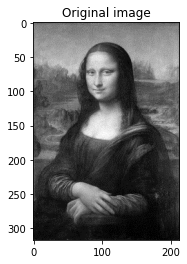

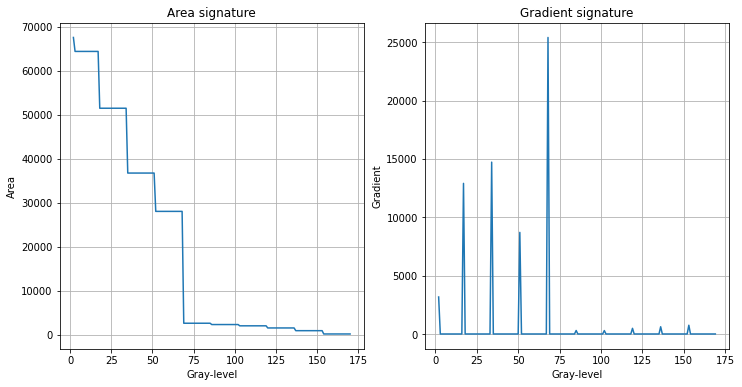

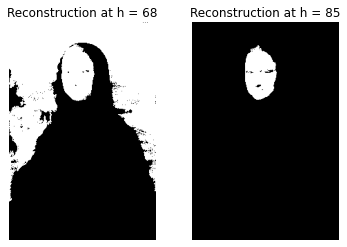

In [ ]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/monalisa.png").convert("L"))
print(img.shape)

#Displaying the image
fig = plt.figure()
plt.imshow(img, cmap='gray')
plt.title("Original image")



#Structuring element with connectivity-4 
Bc = np.zeros((3,3), dtype = bool)
Bc[1,:] = True
Bc[:,1] = True



# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img,Bc)

#Hand-picked regional maxima
x,y = 83,90

# Node corresponding to a regional maximum
node = mxt.node_index[x, y]

# Extracting area attribute from NA
area = mxt.node_array[3,:]

# Area signature computation
levels,signature =  mxt.getSignature(area, node)

#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]

# Display area signature
fig = plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(levels,signature)
plt.grid()
plt.xlabel("Gray-level")
plt.ylabel("Area")
plt.title("Area signature")


# Display gradient of the area signature
plt.subplot(122)
plt.grid()
plt.plot(levels[0:-1],gradient)
plt.xlabel("Gray-level")
plt.ylabel("Gradient")
plt.title("Gradient signature")


# Selecting the peak of the gradient
index = np.argsort(gradient)[::-1][0]

#reconstructing the node corresponding to the peak (largest area)
area1 = signature[index]
node1 = np.where(mxt.node_array[3,:] == area1)[0][0]
cc1 = mxt.recConnectedComponent(node1)

#reconstructing the node corresponding to the peak (smaller area)
area2 = signature[index + 1]
node2 = np.where(mxt.node_array[3,:] == area2)[0][0]
cc2 = mxt.recConnectedComponent(node2)


#Displaying the nodes reconstructed    
fig = plt.figure()
plt.subplot(121)
plt.imshow(cc1, cmap='Greys_r')
plt.axis('off')
plt.title("Reconstruction at h = %d" %mxt.node_array[2,node1])
plt.subplot(122)
plt.imshow(cc2, cmap='Greys_r')
plt.axis('off')
plt.title("Reconstruction at h = %d" %mxt.node_array[2,node2])

### Part 2 artery

**Part 2)** Apply a series of filters to this image to segment the carotid arteries wall

In [118]:
def apply_bounding_box_filter(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max):
    # Building the max-tree of the negated image, i.e. min-tree
    mxt = siamxt.MaxTreeAlpha(img, get_eight_connectivity())

    # Bounding box-lengths
    dx = mxt.node_array[7,:] - mxt.node_array[6,:]
    dy = mxt.node_array[10,:] - mxt.node_array[9,:]
    # Rectangularity ratio
    RR = mxt.computeRR()
    # Node selection criteria
    nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (RR > rr_min) & (RR < rr_max)
    #Filtering the max-tree
    mxt.contractDR(nodes)
    # Recovering the filtered the image
    img_filtered = mxt.getImage()
    return img_filtered


(322, 322)


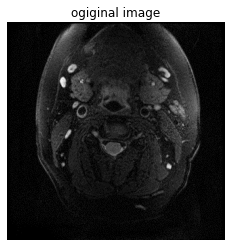

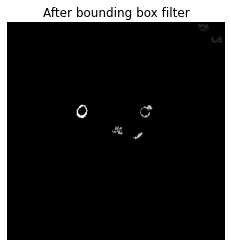

In [141]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/carotid.png").convert("L"))
print(img.shape)

show_image(img, "ogiginal image")

Wmin = 12.99  # Minimum bounding-box width
Hmin = 6.95 # Minimum bounding-box height
Wmax = 17.5 # Maximum bounding-box width
Hmax = 19.5 # Maximum bounding-box height
rr_min = 0.30 # Minimum rectangularity ratio
rr_max = 0.38

img_filtered = apply_bounding_box_filter(img, Wmin, Hmin, Wmax, Hmax, rr_min, rr_max)
show_image(img_filtered, "After bounding box filter")


### Part 3 (filter white spots)

**Parte 3)** Apply a series of filters to remove the white artifacts in the image

(320, 213)


Text(0.5, 1.0, 'area-open, area = 45 ')

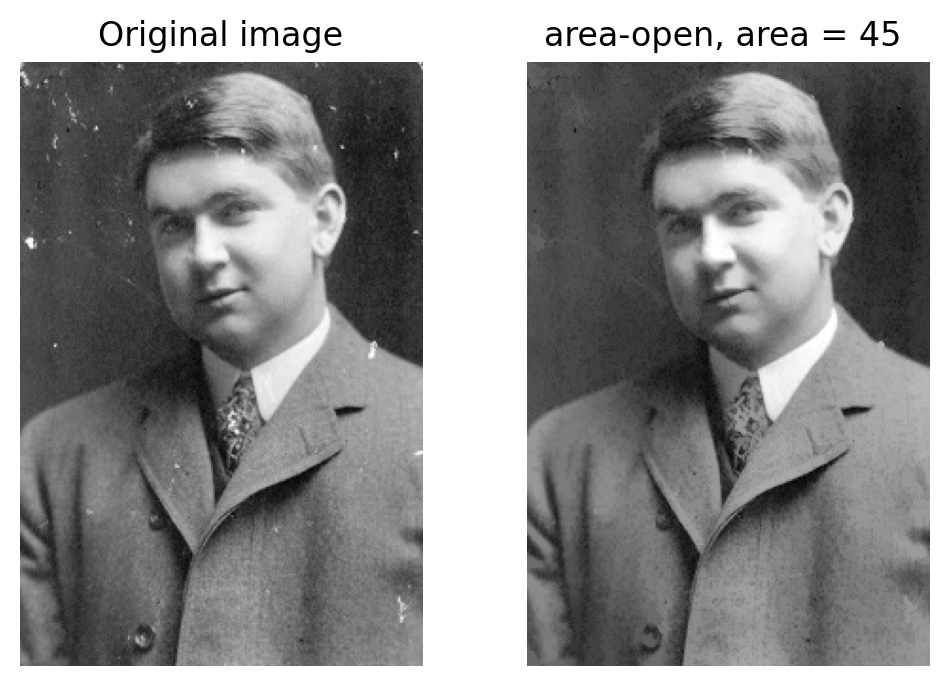

In [ ]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/filtering-image.jpg").convert("L"))
print(img.shape)


#Structuring element with connectivity-8
Bc = np.ones((3,3),dtype = bool)
#Bc[1,:] = True
#Bc[:,1] = True

# Area threshold
area = 45

#applying area filter
img_filtered = apply_area_open_filter(img, Bc, area)

# Negating the image back
#img_filtered = img_max -img_filtered

#Displaying the filtered image
fig = plt.figure(dpi=200)

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(img_filtered, cmap='gray')
plt.axis('off')
plt.title("area-open, area = %d " %area)

### Part 4 (Remove Objects)

**Part 4)** Apply a series of filters that will remove all objects in the image except for the
two pens

In [10]:
#Structuring element with connectivity-4 
Bc = np.zeros((3,3), dtype = bool)
Bc[1,:] = True
Bc[:,1] = True
print(Bc)
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img_org = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/objects.png").convert("L"))
print(img_org.shape)


[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
(381, 384)


#### Experiment with Filters

##### Extinction filter

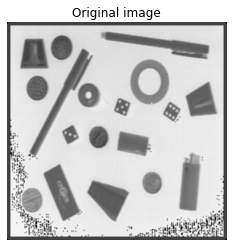

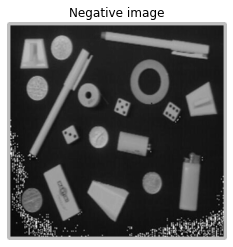

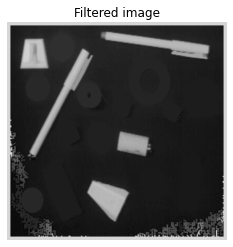

In [32]:
show_image(img, "Original image")
# Recovering the filtered the image
neg_img = get_negative_img(img)
show_image(neg_img, "Negative image")
img_filtered = apply_extinction_filter(neg_img, get_eight_connectivity(), 6)
# img_filtered = get_negative_img(img_filtered)
show_image(img_filtered, "Filtered image")

##### Signature analysis

In [ ]:
show_image(img_org, "Orginal")
img_neg = get_negative_img(img_org)
show_image(img_neg, "Neg image")

# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img_neg, get_eight_connectivity())
print("mxt stats: shape %s" % (str(mxt.node_array.shape)))
#Hand-picked regional maxima. Copied from lecture. No idea what these means
x, y = 83,90
# Node corresponding to a regional maximum. NO idea why this necessary
node = mxt.node_index[x, y]
# Extracting area attribute from NA
area = mxt.node_array[3,:]

# Area signature computation
levels, signature =  mxt.getSignature(area, node)
print("levels: %d %s " % (len(levels), levels))
print(signature)
#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]
# Display area signature
fig = plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(levels, signature)
plt.grid()
plt.xlabel("Gray-level")
plt.ylabel("Area")
plt.title("Area signature")
# Display gradient of the area signature
plt.subplot(122)
plt.grid()
plt.plot(levels[0:-1],gradient)
plt.xlabel("Gray-level")
plt.ylabel("Gradient")
plt.title("Gradient signature")


for ind in range(len(levels)):
    # ind = 2
    # Selecting the second peak of the gradient
    index = np.argsort(gradient)[::-1][ind]
    #reconstructing the node corresponding to the peak (largest area)
    area1 = signature[index]
    node1 = np.where(mxt.node_array[3,:] == area1)[0][0]
    cc1 = mxt.recConnectedComponent(node1)
    #reconstructing the node corresponding to the peak (smaller area)
    area2 = signature[index + 1]
    node2 = np.where(mxt.node_array[3,:] == area2)[0][0]
    cc2 = mxt.recConnectedComponent(node2)

    show_image(cc1, "big")
    show_image(cc2, "small")



##### Area open filter

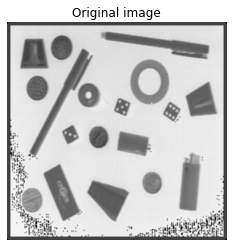

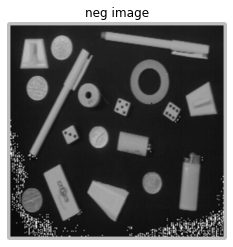

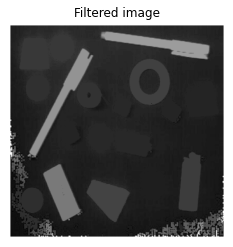

In [41]:
show_image(img, "Original image")
img_neg = get_negative_img(img_org)
show_image(img_neg, "neg image")
img_filtered = apply_area_open_filter(img_neg, Bc, area=3000)
show_image(img_filtered, "Filtered image")

#### Solutions

##### Solution 1

This is an empirically derived solution. Here,
*   we first apply extinction filter to find minimum images where two pen exist. We find an subset image where 4 objects exists.
*   Then we apply open area filter to filter out the other two objects. Finally only the two pen remains.
*   Then we negate the image to find image with only two pens.

Limitation: This approach will not work for all images. This only worked because top 6 maxima points contains the 4 objects with two pen. Open area filter can remove the other two objects because the area of other two object is less than 3000. So, if these objects were larger or the pen's orientation were differnt this we would have to take different approach.

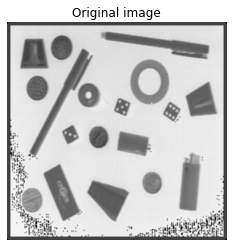

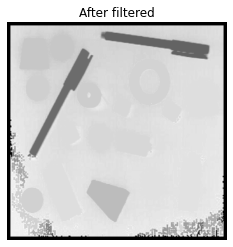

In [45]:
show_image(img, "Original image")
# Recovering the filtered the image
neg_img = get_negative_img(img)
# show_image(neg_img, "Negative image")
img_filtered = apply_extinction_filter(neg_img, get_eight_connectivity(), 6)
# show_image(img_filtered, "Filtered by extinction")
img_filtered = apply_area_open_filter(img_filtered, get_eight_connectivity(), area=3000)
# show_image(img_filtered, "Filtered by open area")
img_pos = get_negative_img(img_filtered)
show_image(img_pos, "After filtered")